In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

In [3]:
test = pd.read_pickle('data/SS3_c57_UMIs_mESC_vs_SS3_c57_UMIs_concat_TEST.pkl')
gene_annotation = pd.read_csv('data/mouse_gene_annotation.csv', index_col=0)
test.drop(gene_annotation['name2'][gene_annotation.chrom == 'chrX'].index.values, errors='ignore', inplace=True)

bf_p = test[2][test[2] != 1][test[2] != 0]
bs_p = test[3][test[3] != 1][test[3] != 0]

bf_mESC = pd.Series([gene[0] for gene in test[0]], index=test.index)
bf_Fib = pd.Series([gene[0] for gene in test[1]], index=test.index)
bs_mESC = pd.Series([gene[2]/gene[1] for gene in test[0]], index=test.index)
bs_Fib = pd.Series([gene[2]/gene[1] for gene in test[1]], index=test.index)
me_mESC  = pd.Series([gene[2]*(gene[0]/(gene[1]+gene[0])) for gene in test[0]], index=test.index)
me_Fib  = pd.Series([gene[2]*(gene[0]/(gene[1]+gene[0])) for gene in test[1]], index=test.index)

bf_p = bf_p.dropna()
bs_p = bs_p.dropna()

In [4]:
from statsmodels.sandbox.stats.multicomp import multipletests

bf_p_fdr = multipletests(bf_p, alpha=0.05, method='fdr_bh')
bs_p_fdr = multipletests(bs_p, alpha=0.05, method='fdr_bh')
print(np.sum(bf_p_fdr[0]))
print(np.sum(bs_p_fdr[0]))
bf_fdr_series = pd.Series(bf_p_fdr[0], index=bf_p.index)
bs_fdr_series = pd.Series(bs_p_fdr[0], index=bs_p.index)
bf_sig_names = bf_fdr_series.index.values[bf_fdr_series]
bs_sig_names = bs_fdr_series.index.values[bs_fdr_series]

1552
1075


# Figure 2a-b

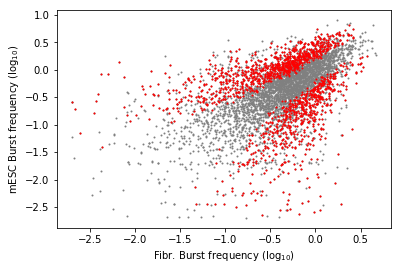

In [5]:
plt.scatter(np.log10(bf_Fib), np.log10(bf_mESC), s = 1, color='Grey')
plt.scatter(np.log10(bf_Fib[bf_sig_names]), np.log10(bf_mESC[bf_sig_names]), s = 1, color='Red')
plt.xlabel('Fibr. Burst frequency (log$_{10}$)')
plt.ylabel('mESC Burst frequency (log$_{10}$)')
plt.savefig('figures/Fig3a.pdf')
plt.show()

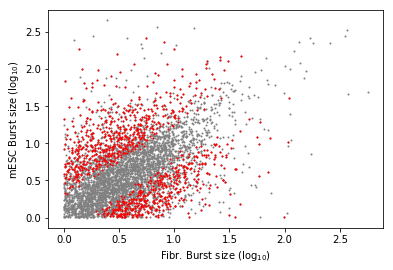

In [6]:
plt.scatter(np.log10(bs_Fib), np.log10(bs_mESC), s = 1, color='Grey')
plt.scatter(np.log10(bs_Fib[bs_sig_names]), np.log10(bs_mESC[bs_sig_names]), s = 1, color='Red')
plt.xlabel('Fibr. Burst size (log$_{10}$)')
plt.ylabel('mESC Burst size (log$_{10}$)')
plt.savefig('figures/Fig3b.pdf')
plt.show()

# Figure 2C

In [7]:
rel_df = pd.DataFrame([np.log2(bf_mESC/bf_Fib),np.log2(bs_mESC/bs_Fib),np.log2(me_mESC/me_Fib)], index=['bf', 'bs', 'me'], columns=test.index).T

rel_df = rel_df.sort_values('me')
rel_df = rel_df[np.absolute(rel_df['me']) < 5]

In [8]:
def bin_array(arr, l = 200):
    binned_arr  = np.array([])
    bin_seq = np.array([])
    for i in range(np.int_(np.floor(len(arr)/l))-1):
        binned_arr = np.append(binned_arr, np.mean(arr[l*i:l*(i+1)]))
        if i == np.int_(np.floor(len(arr)/l))-1:
            bin_seq = np.append(bin_seq, arr[l*i])
            bin_seq = np.append(bin_seq, arr[l*(i+1)])
        else:
            bin_seq = np.append(bin_seq, arr[l*i])
    return binned_arr, bin_seq

In [9]:
n_bins = 50
rel_df['bin'] = pd.cut(rel_df['me'], n_bins, labels = [x for x in np.arange(n_bins)], right=True)

rel_df_median = rel_df.groupby(by='bin').median()

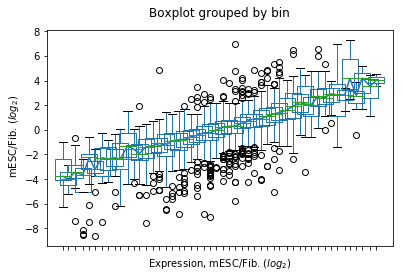

In [10]:
fig, ax = plt.subplots(1, 1)
rel_df.boxplot(column='bf', by='bin', grid = False, ax=ax, rot=45, positions=rel_df_median['me'])
plt.plot(rel_df_median['me'], rel_df_median['bf'])
#plt.plot(rel_df_median['me'], rel_df_median['bs'])
#rel_df.boxplot(column='bs', by='bin', grid = False, ax=ax, showfliers=False, rot=45, positions=rel_df_median['me'])
#ax.set_xticklabels(np.round(rel_df_median['me'],4))
ax.set_xticklabels('')
ax.set_title('')
ax.set_xlabel(r'Expression, mESC/Fib. ($log_2$)')
ax.set_ylabel(r' mESC/Fib. ($log_2$)')
#rel_df.boxplot(column='bs', by='bin', grid = False, ax=ax)
plt.savefig('figures/ExtDataFig5a.pdf')
plt.show()

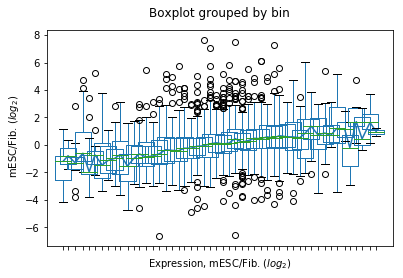

In [11]:
fig, ax = plt.subplots(1, 1)
#rel_df.boxplot(column='bf', by='bin', grid = False, ax=ax, showfliers=False, rot=45, positions=rel_df_median['me'])
#plt.plot(rel_df_median['me'], rel_df_median['bf'])
plt.plot(rel_df_median['me'], rel_df_median['bs'])
rel_df.boxplot(column='bs', by='bin', grid = False, ax=ax, rot=45, positions=rel_df_median['me'])
#ax.set_xticklabels(np.round(rel_df_median['me'],4))
ax.set_xticklabels('')
ax.set_title('')
ax.set_xlabel(r'Expression, mESC/Fib. ($log_2$)')
ax.set_ylabel(r' mESC/Fib. ($log_2$)')
#rel_df.boxplot(column='bs', by='bin', grid = False, ax=ax)
plt.savefig('figures/ExtDataFig5b.pdf')
plt.show()

Ttest_indResult(statistic=-24.629798597721454, pvalue=3.3859382029131138e-62)
Ttest_1sampResult(statistic=-15.378133968504098, pvalue=5.497594241157983e-28)
Ttest_1sampResult(statistic=20.874665464263998, pvalue=4.863197627378701e-38)


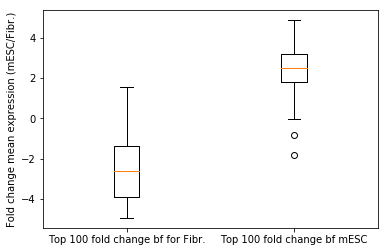

In [12]:
n = 100
rel_df = rel_df.sort_values('bf')
plt.boxplot([rel_df['me'][:n], rel_df['me'][-n:]], labels=['Top 100 fold change bf for Fibr.', 'Top 100 fold change bf mESC'])
plt.ylabel('Fold change mean expression (mESC/Fibr.)')
print(ttest_ind(rel_df['me'][:n], rel_df['me'][-n:]))
print(ttest_1samp(rel_df['me'][:n], 0))
print(ttest_1samp(rel_df['me'][-n:], 0))
plt.savefig('figures/ExtDataFig5c.pdf')
plt.show()

Ttest_indResult(statistic=-5.284085553808783, pvalue=3.317987916286379e-07)
Ttest_1sampResult(statistic=-5.4942128257966765, pvalue=3.0501244850762615e-07)
Ttest_1sampResult(statistic=1.6644770143044012, pvalue=0.09917918508840574)


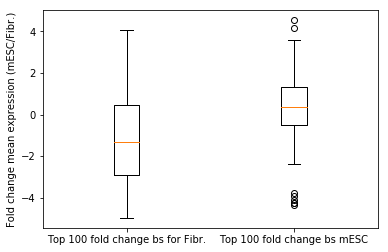

In [13]:
rel_df = rel_df.sort_values('bs')
plt.boxplot([rel_df['me'][:n], rel_df['me'][-n:]], labels=['Top 100 fold change bs for Fibr.', 'Top 100 fold change bs mESC'])
plt.ylabel('Fold change mean expression (mESC/Fibr.)')
print(ttest_ind(rel_df['me'][:n], rel_df['me'][-n:]))
print(ttest_1samp(rel_df['me'][:n], 0))
print(ttest_1samp(rel_df['me'][-n:], 0))
plt.savefig('figures/ExtDataFig5d.pdf')
plt.show()

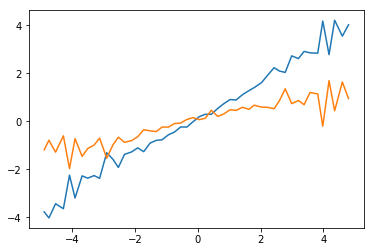

In [14]:
plt.plot(rel_df_median['me'], rel_df_median['bf'])
plt.plot(rel_df_median['me'], rel_df_median['bs'])
plt.savefig('figures/Fig3c.pdf')
plt.show()

# Figure 2D

In [15]:
def convert_to_array(string):
    return np.int_(list(filter(None, string.split(','))))

In [16]:
def get_genes(EPU):
    names = np.array([])
    for tss in EPU:
        names = np.append(TSS.loc[tss]['Gene'], names)
    return np.unique(names)

In [17]:
def map_to_enhancer_manorm(gene, cell_type_fe):
    enhancers = cell_type_fe[cell_type_fe['chr'] == gene['chr']]
    w = np.array([gene['EPU start'] <= enh <= gene['EPU end'] for enh in enhancers['start']])
    enhancers_in_epu = enhancers['M_value'][w]
    return np.mean(enhancers_in_epu)

In [18]:
def log_enh(enh1,enh2):
    if len(enh2) != 0 and len(enh1) != 0:
        return np.log2(np.sum(enh1)/np.sum(enh2))
    else:
        return np.nan

In [19]:
EPU = pd.read_csv('data/EPUs.csv', header=0)
TSS = pd.read_csv('data/TSS_sites.csv', header=0)

TSS.index = TSS['TSS']

EPU['promoters inside the EPU'] = EPU['promoters inside the EPU'].apply(convert_to_array)

EPU_plus_genes = pd.concat([EPU, EPU['promoters inside the EPU'].apply(get_genes)], axis = 1)

EPU_plus_genes.columns = ['chr', 'EPU start', 'EPU end', 'promoters inside the EPU', 'genes inside the EPU']

In [20]:
MEF_fold_enrichment = pd.read_csv('data/MEF_peaks.xls', skiprows=23, sep='\t')
mESC_fold_enrichment = pd.read_csv('data/mESC_peaks.xls', skiprows=23, sep='\t')

manorm_fold_enrichment = pd.read_csv('data/manorm_MEF_mESC_all_MAvalues.xls', sep='\t')

In [21]:
from joblib import delayed, Parallel
enh_MEF = Parallel(n_jobs=50, verbose=3)(delayed(map_to_enhancer_manorm)(epu, manorm_fold_enrichment) for i,epu in EPU_plus_genes.iterrows())

[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:    6.6s
[Parallel(n_jobs=50)]: Done 412 tasks      | elapsed:   13.8s
[Parallel(n_jobs=50)]: Done 700 tasks      | elapsed:   22.8s
[Parallel(n_jobs=50)]: Done 1052 tasks      | elapsed:   34.1s
[Parallel(n_jobs=50)]: Done 1468 tasks      | elapsed:   46.7s
[Parallel(n_jobs=50)]: Done 1948 tasks      | elapsed:  1.1min
[Parallel(n_jobs=50)]: Done 2492 tasks      | elapsed:  1.4min
[Parallel(n_jobs=50)]: Done 3100 tasks      | elapsed:  1.7min
[Parallel(n_jobs=50)]: Done 3772 tasks      | elapsed:  2.1min
[Parallel(n_jobs=50)]: Done 4508 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done 5308 tasks      | elapsed:  2.8min
[Parallel(n_jobs=50)]: Done 6172 tasks      | elapsed:  3.1min
[Parallel(n_jobs=50)]: Done 7100 tasks      | elapsed:  3.4min
[Parallel(n_jobs=50)]: Done 8092 tasks      | elapsed:  3.8min
[Parallel(n_jobs=50)]: Done 8792 out of 8792 | elapsed:  4.

In [22]:
EPU_plus_genes['enh_manorm'] = enh_MEF

In [23]:
gene_name = []
log_enh_list = []
for i,row in EPU_plus_genes.iterrows():
    g_inside = row['genes inside the EPU']
    l_enh = row['enh_manorm']
    gene_name.extend(g_inside)
    log_enh_list.extend(np.repeat(l_enh, len(g_inside)))

In [24]:
log_enh_series = pd.Series(log_enh_list, index=gene_name).dropna()

log_enh_series = log_enh_series[~log_enh_series.index.duplicated(keep='first')]

enh_df = pd.DataFrame([np.log2(bf_mESC/bf_Fib),np.log2(bs_mESC/bs_Fib), -log_enh_series], index=['bf', 'bs', 'enh']).T.dropna(how='any')

enh_df['enh'] = enh_df['enh'] - np.mean(enh_df['enh'])

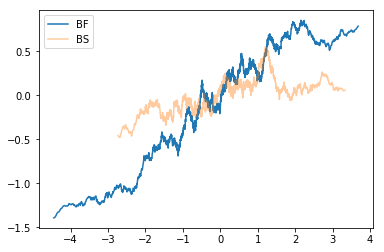

In [25]:
enh_df = enh_df.sort_values('bf')
rolling_bf = enh_df.rolling(200).mean().dropna()
plt.plot(rolling_bf['bf'], rolling_bf['enh'], label='BF')
enh_df = enh_df.sort_values('bs')
rolling_bs = enh_df.rolling(200).mean().dropna()
plt.plot(rolling_bs['bs'], rolling_bs['enh'],alpha=0.4,  label='BS')
plt.legend()
plt.savefig('figures/Fig3d.pdf')
plt.show()

Ttest_indResult(statistic=-11.401588799591433, pvalue=1.776718669215198e-23)
Ttest_1sampResult(statistic=-8.801852050527312, pvalue=4.4655256091184455e-14)
Ttest_1sampResult(statistic=7.260607917846643, pvalue=8.864615267037344e-11)


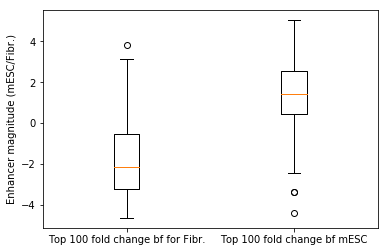

In [26]:
n = 100
enh_df = enh_df.sort_values('bf')
plt.boxplot([enh_df['enh'][:n], enh_df['enh'][-n:]], labels=['Top 100 fold change bf for Fibr.', 'Top 100 fold change bf mESC'])
plt.ylabel('Enhancer magnitude (mESC/Fibr.)')
print(ttest_ind(enh_df['enh'][:n], enh_df['enh'][-n:]))
print(ttest_1samp(enh_df['enh'][:n], 0))
print(ttest_1samp(enh_df['enh'][-n:], 0))
plt.savefig('figures/ExtDataFig5e.pdf')
plt.show()

Ttest_indResult(statistic=-1.804977940350096, pvalue=0.0725974269409498)
Ttest_1sampResult(statistic=-2.7157137557541646, pvalue=0.0078049233408416865)
Ttest_1sampResult(statistic=-0.20598405788940996, pvalue=0.8372263631661159)


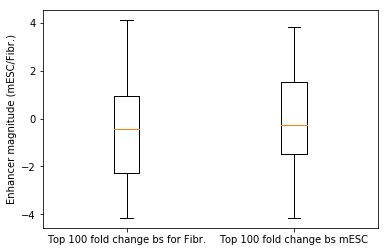

In [27]:
enh_df = enh_df.sort_values('bs')
plt.boxplot([enh_df['enh'][:n], enh_df['enh'][-n:]], labels=['Top 100 fold change bs for Fibr.', 'Top 100 fold change bs mESC'])
plt.ylabel('Enhancer magnitude (mESC/Fibr.)')
print(ttest_ind(enh_df['enh'][:n], enh_df['enh'][-n:]))
print(ttest_1samp(enh_df['enh'][:n], 0))
print(ttest_1samp(enh_df['enh'][-n:], 0))
plt.savefig('figures/ExtDataFig5f.pdf')
plt.show()